# Transfer Learning

In [1]:
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install ipywidgets
!pip install widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt

# Use tf.keras for tasks 1 and 2
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras.datasets import cifar10

# Use keras for Tasks 3, 4, 5.
from keras.layers import Dense,GlobalAveragePooling2D, Conv2D, Dropout, MaxPooling2D, Input, Flatten
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from ipywidgets import FloatProgress

## Task 0: Load the data
tf.data.Dataset exposes about 29 preprocessed datasets for developers to easliy load and experiment with test datasets.

For the first task, the focus is on tf_flowers. 

**0.1.** The tf_flowers dataset is not split into train, test and validation. So we need to do that by hand, using **tfds.Split.TRAIN.subsplit** method.

**0.2.** Load the dataset using the **tfds.load()** method. Check the documentation for more options on the arguments. Two of the optional arguments that shall be used here are:
- **with_info** - is True, which gives the metadata about the dataset.
- **as_supervised** - is True, which returns the data and label as a tuple (input, label).

**0.3.** Check out the metadata. From this we can see there are a total of 3670 images. After the split, 2950 training images are left.

**0.4.** Pre-process the images. Define a function that resize each image to (32, 32), casts it to float and downscales the pixel values by 255. Map this function over the dataset.

**0.5.** Use the map function to call the preprocessor on every element of the dataset.

**0.6.** A few more operations on the dataset:
  - i) Shuffle the training set. Use the SHUFFLE_BUFFER_SIZE constant as argument.
  - ii) Batch all the three sets (train, validation and test).
  - iii) Prefetch the training data in order to overcome the bottleneck b/w represented by the CPU.
 


In [4]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32
IMG_SIZE = 32
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
SPLIT_WEIGHTS = (8, 1, 1)

# 0.1. Use subsplit from tfds in order to split the tf_flowers dataset
splits = ["train[:80%]","train[80%:90%]","train[90%:]"]     
# 0.2. Load the datset
(raw_train, raw_val, raw_test), metadata = tfds.load(
                                                'tf_flowers',
                                                split=splits,
                                                with_info=True,
                                                as_supervised=True)

# 0.3. Check the metadata to find out the number of samples in each set
num_train, num_val, num_test = (
                                metadata.splits['train'].num_examples * weight/10 \
                                for weight in SPLIT_WEIGHTS
                                )

print('Number of training samples {}'.format(num_train))

# 0.4. Define a method to pre-process the images
def resize_normalize(img, label):
    # i) TODO: Use tf.cast to convert the pixels to tf.float32
    img = tf.cast(img, dtype=tf.float32)
    # ii) TODO: Resize the image to the desired size: 32x32 (use the method from tf)
    img = tf.image.resize(img, size=[32,32])
    # iii) TODO: Normalize the pixel values: all channels are b/w 0 and 1
    img = img / 255.

    return img, label

# 0.5. Map the function defined above over the dataset (on each split)
train = raw_train.map(resize_normalize)
val = raw_val.map(resize_normalize)
test = raw_test.map(resize_normalize)

# # 0.6. Other preprocessings

# # i) Shuffle the training size
train = train.shuffle(SHUFFLE_BUFFER_SIZE)

# # ii) Batch each of the 3 sets: train, validation and test
train = train.batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

# iii) Prefetch: AUTOTUNE.
train = train.prefetch(tf.data.AUTOTUNE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training samples 2936.0


## Task 1: Build a base model

**1.1.** Define a convolutional neural network with the following architecture:
  - **1.1.1.** 3 convolutional layers with 5x5 kernels, same padding and relu activation. After the 1st and 2nd CONV layers, add also MaxPooling, with filters of size 2.
  - **1.1.2.** 2 fully connected layers: the first with 128 neurons and relu activation; the second should be used for classification, with softmax activation.

In [5]:
# 1.1. Create the model
def create_model():
    img_inputs = keras.Input(shape=IMG_SHAPE)

    # 1.1.1. Add 3 CONV layers, 5x5, same padding and relu activations; 32, 64, 64 neurons
    conv_1 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(img_inputs)
    max_pooling1 = MaxPooling2D((2, 2))(conv_1)
    conv_2 = Conv2D(64, kernel_size=5, padding='same', activation='relu')(max_pooling1)
    max_pooling2 = MaxPooling2D((2, 2))(conv_2)
    conv_3 = Conv2D(64, kernel_size=5, padding='same', activation='relu')(max_pooling2)

    # 1.1.2. Flatten
    flatten = keras.layers.Flatten()(conv_3)

    # 1.1.3. Dense layers x 2: (128, relu), (5, softmax)
    dense_1 = Dense(128, activation='relu')(flatten)
    output = Dense(5, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)
    
    return model

base_model = create_model()
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          102464

In [6]:
# Number of train, validation and test samples
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples * weight/10 for weight in SPLIT_WEIGHTS
)

# Compute the number of steps per epoch such that all the train and validation sets are covered.
steps_per_epoch = round(num_train) // BATCH_SIZE
validation_steps = round(num_val) // BATCH_SIZE

# Print the information about train, test and validation data
print('Number of examples in the train set:', num_train)
print('Number of examples in the validation set:', num_val)
print('Number of examples in the test set:', num_test)


Number of examples in the train set: 2936.0
Number of examples in the validation set: 367.0
Number of examples in the test set: 367.0


**1.2.** Train the network for a few iterations and save the model.
  - **1.2.1.** Compile the model: adam, sparse_categorical_cross_entropy, accuracy as metric.
  - **1.2.2.** Train. For the train and validation data use the repeat() function, to keep spinning the data and reuse it as the steps per epoch cause us to reach the end of the dataset. Please note that specifying the number of train and validation steps is mandatory in this case (when using repeat()).


Note: \\
Please take into account the fact that the amount of data is really small. Do not spend too much time trying to improve the performance of the model, as there are many other tasks left and those will give you more new knowledge to be further used and refined. The aim of this lab is to understand the know-hows of transfer learning and to be able to implement it. Not the performance of the models. Time permitting, you can, of course, do that as well.

In [7]:
# 1.2. Train
def train_model(model):
    # 1.2.1. TODO: Compile
    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    # 1.2.2. TODO: Fit
    train_data = train.repeat(12)
    val_data = val.repeat(12)
    history = model.fit(train_data, validation_data=val_data, steps_per_epoch=10, epochs=5, batch_size=32, shuffle=True)
    
    return history

history = train_model(base_model)

Epoch 1/5
10/10 [==============================] - 19s 430ms/step - loss: 1.6122 - accuracy: 0.2438 - val_loss: 1.5954 - val_accuracy: 0.2425
Epoch 2/5
10/10 [==============================] - 3s 277ms/step - loss: 1.5904 - accuracy: 0.2625 - val_loss: 1.5451 - val_accuracy: 0.3243
Epoch 3/5
10/10 [==============================] - 3s 290ms/step - loss: 1.4803 - accuracy: 0.3469 - val_loss: 1.3510 - val_accuracy: 0.3951
Epoch 4/5
10/10 [==============================] - 3s 313ms/step - loss: 1.3836 - accuracy: 0.4250 - val_loss: 1.3691 - val_accuracy: 0.4223
Epoch 5/5
10/10 [==============================] - 2s 241ms/step - loss: 1.3945 - accuracy: 0.4156 - val_loss: 1.2708 - val_accuracy: 0.4741


## Task 2: Transfering to a new task

**2.1.** Load the cifar10 dataset. 

In [8]:
num_classes = 10

# 2.1. Load cifar10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**2.2.** Keep all the convolutional and max pooling layers from the base model (trained on tf flowers). On top of them we will define two new dense layers and train the entire model on the new dataset.
  - **2.2.1.** If your first model followed the specified architecture, the flattening layer applied after the convolutions should be model.layer[-3] to get its output we simply use model.layers[-3].output.
  - **2.2.2.** Build 2 new fully connected layers on top of the base model.

**2.3.** Define a new model that outputs the result from our newly created layers. Use **tf.keras.model**.

**2.4.** Compile the new model: Adam as optimizer, loss sparse categorical crossentropy, accuracy as metric.

**2.5.** Train the new model on cifar10.

In [23]:
# 2.2. Reuse the base model
print("Base model's weights: ", len(base_model.weights))
print("Trainable weights: ", len(base_model.trainable_weights))
print("Non-trainable weights: ", len(base_model.non_trainable_weights))

# 2.2.1. Keep only the convolutional and max pooling layers from the base model.
x = base_model.input
conv_output = base_model.layers[-3].output

# 2.2.2. Build new layers on top of the base model (e.g. (relu, 128 neurons), (10, softmax)
fc_1 = Dense(128, activation='relu')(conv_output)
fc_2 = Dense(10, activation='softmax')(fc_1)

# 2.3. Define a new model that outputs the result from our newly created layers
new_model = tf.keras.Model(x, fc_2)

# 2.4. Compile the model: TODO
new_model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 2.5. Train on cifar
new_history = new_model.fit(x=x_train, y=y_train,
                            batch_size=32, epochs=10,
                            validation_data=(x_test, y_test),
                            shuffle=True)

Base model's weights:  10
Trainable weights:  10
Non-trainable weights:  0
Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.6014 - accuracy: 0.4384 - val_loss: 1.3842 - val_accuracy: 0.5078
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2808 - accuracy: 0.5488 - val_loss: 1.3305 - val_accuracy: 0.5403
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1560 - accuracy: 0.5951 - val_loss: 1.2389 - val_accuracy: 0.5718
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0578 - accuracy: 0.6318 - val_loss: 1.1477 - val_accuracy: 0.6021
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9801 - accuracy: 0.6577 - val_loss: 1.1680 - val_accuracy: 0.6084
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9252 - accuracy: 0.6800 - val_loss: 1.1649 - val_accuracy: 0.6154
Epoch 7/10
1563/1563 [==============================] - 8s 5m

## Task 3: Loading Keras Pretrained Models

### STEP 1: Build the model

**3.1.** Load the ResNet50 model from Keras, pretrained on ImageNet (a dataset with 1000 classes and millions of training examples). 

**3.2.** The ResNet50 model has 1000 neurons in the last layer (one for each class). We want as many neurons in the last layer of the network as the number of classes in the current problem. Thus we need to discard the 1000 neuron layer and add our own last layer.
*Hint*: Set *IncludeTop=False* when importing the model.

**3.3.** Add a few **dense layers** such that our model learns more complex functions. The dense layers have **relu as activation** function and the **last layer**, with **as many neurons as the number of classes** has **softmax as activation**.

**3.4.** Build a model on the architecture provided.

In [45]:
# Download the flowers dataset
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
print(base_dir)

# Some constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

/root/.keras/datasets/flower_photos


In [79]:
"""
  Reference: https://www.tensorflow.org/tutorials/images/transfer_learning
"""

# 3.1. Import the model, 3.2. without the last layer
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False)

# base_model.trainable = False
base_model.trainable= True

inputs = base_model.input
x = base_model.output

# Add GlobalAveragePooling
x = GlobalAveragePooling2D()(x)

# 3.3. i) Add 2 dense layers: 32, 32, relu
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# 3.3. ii) Add a final dense layer: 5, softmax
predictions = Dense(5, activation='softmax')(x)

# 3.4. Build the model
model = tf.keras.Model(inputs, predictions)

# Uncomment below to check the architecture of the model
for i,layer in enumerate(model.layers):
   print(i,layer.name)

# TASK 4/5: Play later with freezing/unfreezing some or all the layers of the base network
for layer in model.layers[:80]:
  layer.trainable=False

print("Trainable layers: ", len(model.trainable_weights))

0 input_15
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_b

### Step 2: Load the training data into the ImageDataGenerator

ImageDataGeneator is a class from keras, that can help us to train our model. All we need to do is specify the path to our training data and it automatically sends the data for training, in batches. It makes the code much simpler. 

**3.5.** Use ImageDataGenerator with rescale 1./255 and validation split of 0.2 (80/20).

**3.6.** Create the train generator and specify where the train dataset directory, image size, batch size.

**3.7.** Create the validation generator with similar approach as the train generator with the flow_from_directory() method.


In [80]:
# 3.5. Rescale the images using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

# 3.6. Use flow_from_directory to specify the base_dir, target_size, batch_size and subset: 'training'
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

# 3.7. For subset: 'validation', use a similar approach as in 3.6.
val_generator = train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


### STEP 3: Train on the dataset

**3.8.**  Compile the model using **categorical crossentropy**, **accuracy as metric** and **Adam as optimizer**.

**3.9.** Train using **train_generator** as **generator**, **step_size_train** as **steps_per_epoch**, and **10 epochs**. 

In [81]:
# 3.8. TODO: Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 3.9. Train the model
history = model.fit(train_generator, validation_data=val_generator, steps_per_epoch=20, epochs=10)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [82]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [66]:
# Plot the learning curves
def plot_lc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,13.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

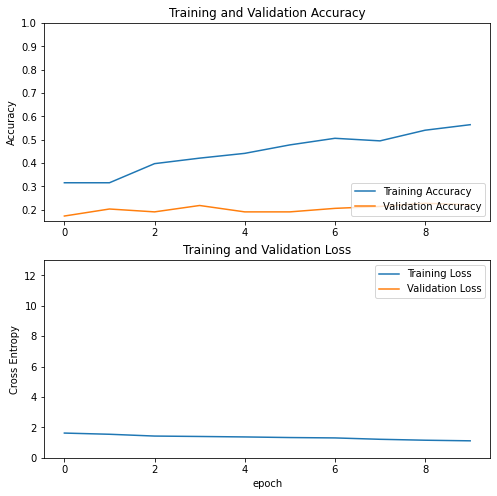

In [83]:
plot_lc(history)

## Task 4: Freezing layers in tf.keras

You can specify whether the variables from a layer should be updated or not during the training process by setting the layers , trainable attribute. For instance you can see that all the layers from the loaded model have this paremeter set to True if you iterate through them.

```
for layer in model.layers:
  print(layer.trainable)
```

If you want to freeze them (i.e. not update their weights during training) you can set the parameter to False.

```
for layer in model.layers:
  layer.trainable = False
```

Try this in the architecture above and see what happens.

## Task 5: Gradually unfreezing layers

For some tasks, the weights learned by the base network are not appropriate enough to constitute a final solution and you might have to update the entire network during training.

To avoid training a network that has a highly refined first set of layers and a randomly initialized couple of last layers, a suggested approach is to fine tune the added layers and then gradually unfreeze the layers starting from the top as the training progresses.

As a last task you should implement this approach. You can use a smaller pretrained network such as VGG16 or set up a small amount of iterations between each un freezing.

You can add these changes directly to Task 3 and check the outcomes.